In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import unittest
import colorama
import pandas as pd
import numpy as np
from tqdm import tqdm

from communication.message.MessagePerformative import MessagePerformative
from communication.preferences.CriterionName import CriterionName
from communication.preferences.CriterionValue import CriterionValue
from communication.preferences.Item import Item
from communication.preferences.Preferences import Preferences
from communication.preferences.Value import Value
from pw_argumentation import ArgumentModel, format_argument, generate_pref_df, generate_preferences

colorama.init()  # INFO: used to print colored text on Windows

## An example conversation between 2 agents

### Performance Tables

In [3]:
drop_prefs = False

In [4]:
# Find a long conversation
# for _ in range(100):
#     prefs_1, df1 = generate_preferences(drop_prefs=drop_prefs)
#     prefs_2, df2 = generate_preferences(drop_prefs=drop_prefs)
#     argument_model = ArgumentModel([prefs_1, prefs_2])
#     argument_model.run_model()

#     results, history = argument_model.get_final_result()
#     if len(history)>15:
#         print("Found it")
#         break

In [437]:
prefs_1, df1 = generate_preferences(drop_prefs=drop_prefs)
print("Agent 1 preferences:")
df1

,ENVIRONMENT_IMPACT,CONSUMPTION,PRODUCTION_COST,DURABILITY,NOISE
item1,0,2,3,1,4
item2,4,4,3,3,2


In [438]:
prefs_2, df2 = generate_preferences(drop_prefs=drop_prefs)
print("Agent 2 preferences:")
df2

,PRODUCTION_COST,DURABILITY,NOISE,CONSUMPTION,ENVIRONMENT_IMPACT
item1,1,0,3,0,4
item2,1,1,1,1,4


In [439]:
argument_model = ArgumentModel([prefs_1, prefs_2])
argument_model.run_model()

results, history = argument_model.get_final_result()
if results:
    print("Winning agent:", results["winning_agent"])
    print("Winning item:", results["winning_item"])
    print("Winning argument:", format_argument(results["winning_argument"]))

history

Winning agent: A1
Winning item: item2
Winning argument: item2, ENVIRONMENT_IMPACT==VERY_GOOD and ENVIRONMENT_IMPACT>CONSUMPTION


,sender,receiver,performative,item,decision,main_criterion,value,secondary_criterion
0,A1,A2,PROPOSE,item2,None,None,None,None
1,A2,A1,ASK_WHY,item2,None,None,None,None
2,A1,A2,ARGUE,item2,pro,CriterionName.ENVIRONMENT_IMPACT,Value.VERY_GOOD,None
3,A2,A1,ARGUE,item2,con,CriterionName.PRODUCTION_COST,Value.BAD,CriterionName.ENVIRONMENT_IMPACT
4,A1,A2,ARGUE,item2,pro,CriterionName.CONSUMPTION,Value.VERY_GOOD,CriterionName.PRODUCTION_COST
5,A2,A1,ARGUE,item2,con,CriterionName.DURABILITY,Value.BAD,CriterionName.CONSUMPTION
6,A1,A2,ARGUE,item2,pro,CriterionName.ENVIRONMENT_IMPACT,Value.VERY_GOOD,CriterionName.DURABILITY
7,A2,A1,ARGUE,item2,con,CriterionName.NOISE,Value.BAD,CriterionName.ENVIRONMENT_IMPACT
8,A1,A2,ARGUE,item2,pro,CriterionName.CONSUMPTION,Value.VERY_GOOD,CriterionName.NOISE
9,A2,A1,ARGUE,item2,con,CriterionName.PRODUCTION_COST,Value.BAD,CriterionName.CONSUMPTION


## Start negotiations

We start by setting up agents preferences

In [87]:
from collections import namedtuple
n_items = 5
n_agents = 10
drop_prefs = False
Agent = namedtuple("Agent", ["name", "prefs", "pref_df"])
agents = []
for i in range(n_agents):
    prefs, df = generate_preferences(drop_prefs=drop_prefs, n_items = n_items)
    agents.append(Agent(name=f"A{i}", prefs=prefs, pref_df=df))

print(f"Generated {n_agents} agents with {n_items} items")
print("First agent preferences:")
agents[0].pref_df

Generated 10 agents with 5 items
First agent preferences:


,DURABILITY,CONSUMPTION,ENVIRONMENT_IMPACT,NOISE,PRODUCTION_COST
item1,1,0,2,0,2
item2,0,4,2,4,0
item3,3,0,1,0,0
item4,2,3,4,4,2
item5,2,1,2,3,0


Let the games begin!

100%|██████████| 10/10 [00:00<00:00, 20.88it/s]


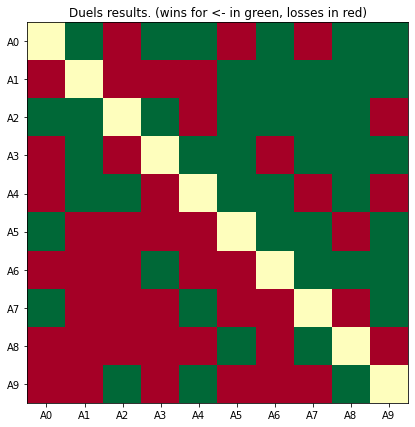

In [94]:
verbose = False
duels_results = np.zeros((n_agents, n_agents))
winning_items = []
winning_arguments = []
for i in tqdm(range(n_agents)):
    for j in range(i+1, n_agents):
        agent_1 = agents[i]
        agent_2 = agents[j]

        argument_model = ArgumentModel([agent_1.prefs, agent_2.prefs], [agent_1.name, agent_2.name])
        argument_model.run_model()

        results, history = argument_model.get_final_result()
        if verbose:
            if results:
                print("Winning agent:", results["winning_agent"])
                print("Winning item:", results["winning_item"])
                print("Winning argument:", format_argument(results["winning_argument"]))
            else:
                print("No results")

        # find winning agent
        if results:
            if results["winning_agent"] == agent_1.name:
                duels_results[i, j] = 1
                duels_results[j, i] = -1
            else:
                duels_results[i, j] = -1
                duels_results[j, i] = 1

            winning_items.append(results["winning_item"])
            winning_arguments.append(results["winning_argument"])
        else:
            duels_results[i, j] = 0
            duels_results[j, i] = 0
            
plt.rcParams["figure.figsize"] = (7, 7)
plt.imshow(duels_results, cmap='RdYlGn')
plt.xticks(range(n_agents), [agent.name for agent in agents])
plt.yticks(range(n_agents), [agent.name for agent in agents])
plt.title("Duels results. (wins for <- in green, losses in red)")
plt.show()

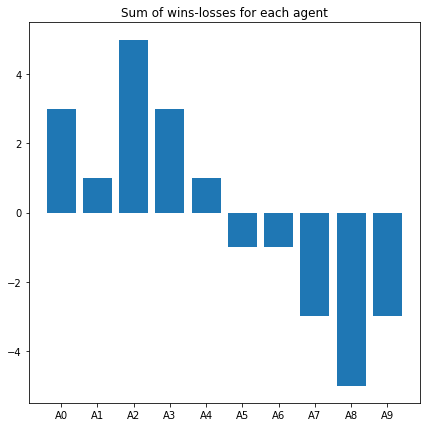

In [89]:
import matplotlib.pyplot as plt
plt.bar(range(n_agents), np.sum(duels_results, axis=1), tick_label=[agent.name for agent in agents])
plt.title("Sum of wins-losses for each agent")
plt.show()

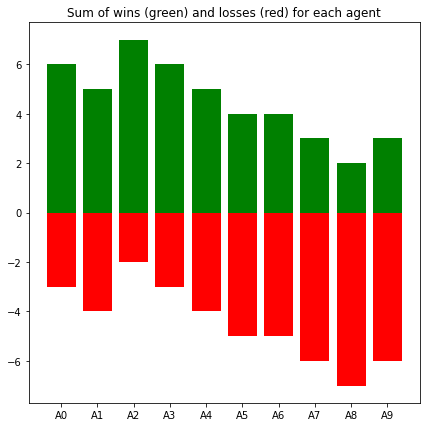

In [90]:
import matplotlib.pyplot as plt
# plot in green sum of wins and in red sum of losses
plt.bar(range(n_agents), np.sum(duels_results>0, axis=1), tick_label=[agent.name for agent in agents], color="green")
plt.bar(range(n_agents), -np.sum(duels_results<0, axis=1), tick_label=[agent.name for agent in agents], color="red")

plt.title("Sum of wins (green) and losses (red) for each agent")
plt.show()

In [91]:
# Winning agent
winner_idx = np.argmax(np.sum(duels_results, axis=1))
print(f"Winner: {agents[winner_idx].name}")
agents[winner_idx].pref_df

Winner: A2


,CONSUMPTION,PRODUCTION_COST,NOISE,DURABILITY,ENVIRONMENT_IMPACT
item1,2,4,2,3,3
item2,4,2,4,0,2
item3,3,4,1,4,2
item4,1,2,2,0,1
item5,1,2,1,3,3


Most winning items:
item4    15
item2    12
item5     5
item1     4
item3     3
dtype: int64


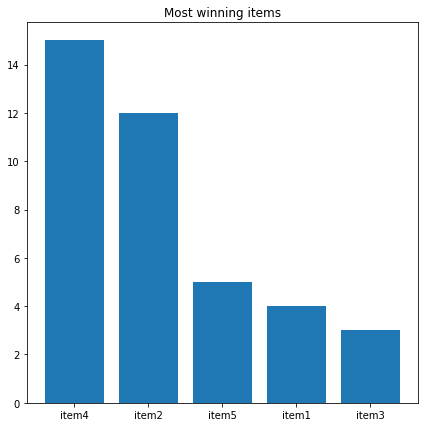

In [92]:
# most winning items
winning_items = pd.Series(winning_items)
winning_items = winning_items.value_counts().sort_values(ascending=False)
print("Most winning items:")
print(winning_items)
plt.bar(range(len(winning_items)), winning_items.values, tick_label=winning_items.index)
plt.title("Most winning items")
plt.show()

Most winning criteria:
CONSUMPTION           12
DURABILITY            10
PRODUCTION_COST       10
NOISE                  8
ENVIRONMENT_IMPACT     5
dtype: int64


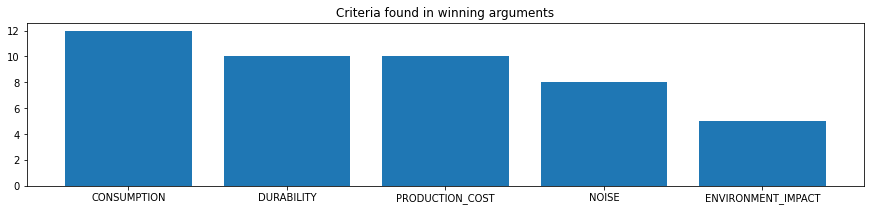

In [93]:
# most winning criteria
winning_criteria = [arg['main_criterion'].name for arg in winning_arguments]
winning_criteria = pd.Series(winning_criteria)
winning_criteria = winning_criteria.value_counts().sort_values(ascending=False)
print("Most winning criteria:")
print(winning_criteria)
plt.rcParams['figure.figsize'] = (15, 3)
plt.bar(range(len(winning_criteria)), winning_criteria.values, tick_label=winning_criteria.index)
plt.title("Criteria found in winning arguments")
plt.show()